In [1]:
from comet_ml import Experiment
import numpy as np
import os
import torch
from tqdm import tqdm
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from concrete_cracks_dataset import ConcreteCracksDataset
from concrete_cracks_model import ConcreteCracksModel
from Unet import Unet

API_KEY = os.environ['COMETKEY']
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Important note, if batch requires more memory than gpu has it starts to copy values, because of that performance drastically decrease. It is about 25 times slower
hyper_params = {
    'learning_rate': 0.0001,
    'epochs': 5,
    'batch_size': 5, 
    'negative_samples': 3,
    'positive_samples': 7,
}

In [2]:
experiment = Experiment(
  api_key = API_KEY,
  project_name = 'concrete-cracks-segmentation',
  workspace='my-projects'
)
experiment.log_parameters(hyper_params)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/my-projects/concrete-cracks-segmentation/683062791705490d81fe211426624cb5



In [3]:
model = Unet(ch_in=3, ch_out=1).to(DEVICE)
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=hyper_params['learning_rate'])
scaler = torch.cuda.amp.grad_scaler.GradScaler()

train_dataset = ConcreteCracksDataset(transform=ToTensor(),n_negative=hyper_params['negative_samples'], n_positive=hyper_params['positive_samples'], skip=10)
train_loader = DataLoader(dataset=train_dataset, batch_size=hyper_params['batch_size'], shuffle=True, num_workers=1)

val_dataset = ConcreteCracksDataset(transform=ToTensor(),n_negative=5, n_positive=5, skip=0)
val_loader = DataLoader(dataset=val_dataset, batch_size=hyper_params['negative_samples'] + hyper_params['positive_samples'], shuffle=False, num_workers=1)

In [4]:
def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)
    for i, (images, masks) in enumerate(loop):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        # forward
        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = loss_fn(outputs, masks)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())

def log_images(loader, model, epoch, experiment):
    model.eval()
    test_images, test_masks = next(iter(val_loader))
    with torch.no_grad():
        output = model(test_images.cuda())
    model.train()

    for i in range(test_images.shape[0]):
        #converting dimensions to HWC
        img = test_images[i].permute(1,2,0)
        msk = test_masks[i].permute(1,2,0)
        predict = output[i].permute(1,2,0).cpu()
     
        #log images to comet
        step = (epoch+1)*len(train_dataset)
        experiment.log_image(img, f'image{i+1}', step=step)
        experiment.log_image(msk, f'mask{i+1}', step=step)
        experiment.log_image(predict*255, f'predict{i+1}', step=step) #*255 makes it more visible in comet
    


In [5]:
for epoch in range(hyper_params['epochs']):
    train_fn(train_loader, model, optimizer, loss_fn, scaler)

    log_images(val_loader, model, epoch, experiment)

100%|██████████| 2/2 [00:03<00:00,  1.76s/it, loss=0.486]


Showing results

In [6]:
import matplotlib.pyplot as plt
image, mask = next(iter(val_loader))

image = image.to(DEVICE)
mask = mask.to(DEVICE)

# it is important to use it like to to decrease memory usage
model.eval()
with torch.no_grad():
    predict = model(image)
model.train()

Unet(
  (ups): ModuleList(
    (0): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (2): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
    (3): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), p

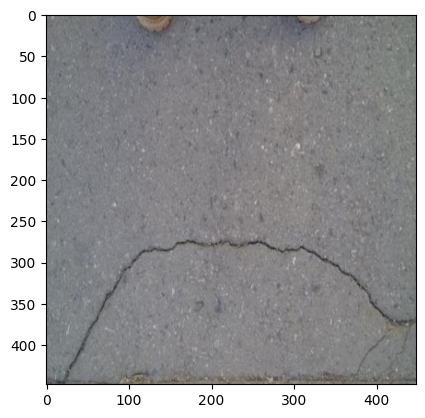

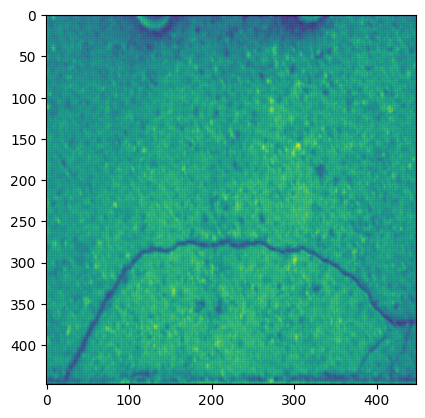

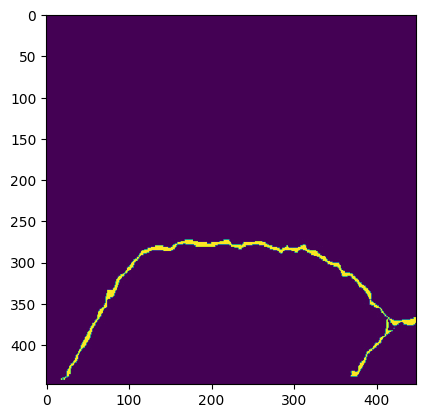

In [9]:
i = 8 # i in range(0, batch_size-1)
img_dim = image[i].permute(1, 2, 0).cpu()
predict_dim = predict[i].permute(1,2,0).cpu()
msk_dim = mask[i].permute(1,2,0).cpu()
plt.imshow(img_dim)
plt.show()
plt.imshow(predict_dim)
plt.show()
plt.imshow(msk_dim*255)

In [ ]:
model_state_file = 'model_versions/filename'

torch.save(model.state_dict(), model_state_file)
#experiment.log_model('name on comet', model_state_file)

In [ ]:
experiment.end()